In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

fer2013.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/fer2013.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
import os

In [ ]:
train_data = '/content/train'
validation_data = '/content/test'

In [ ]:
train_datagen = ImageDataGenerator(
                    rescale =1./255,
                    rotation_range = 30,
                    shear_range=0.3,
                    zoom_range=0.3,
                    horizontal_flip=True,
                    fill_mode='nearest'

)
validation_datagen = ImageDataGenerator(
                        rescale=1.255
)

In [ ]:
train_generator = train_datagen.flow_from_directory(
    train_data,
    color_mode = 'grayscale',

    batch_size=32,
    target_size=(48,48),
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    validation_data,
    color_mode = 'grayscale',

    batch_size=32,
    target_size=(48,48),
    class_mode='categorical',
    shuffle=True
)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
class_labels= ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

In [ ]:
img,label = train_generator.__next__()

In [ ]:
model = Sequential()

model.add(Conv2D(32,kernel_size =(3,3),padding='valid',activation='relu',input_shape=(48,48,1)))


model.add(Conv2D(64,kernel_size =(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2),strides =2,padding='valid'))
model.add(Dropout(0.1))

model.add(Conv2D(128,kernel_size =(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2),strides =2,padding='valid'))
model.add(Dropout(0.1))

model.add(Conv2D(64,kernel_size =(3,3),padding='valid',activation='relu'))
model.add(MaxPooling2D(pool_size =(2,2),strides =2,padding='valid'))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dense(164,activation='relu'))

model.add(Dense(7,activation='softmax'))

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 conv2d_41 (Conv2D)          (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 22, 22, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 22, 22, 64)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 10, 10, 128)       0         
 ng2D)                                                

In [ ]:
train_path = "data/train"
test_path  = "data/test"
num_train_imgs = 0
for root,dirs,files in os.walk(train_path):
  num_train_imgs+=len(files)

num_test_imgs = 0
for root,dirs,files in os.walk(test_path):
  num_test_imgs+=len(files)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=4,
                               restore_best_weights=True)

# Model training with EarlyStopping
history = model.fit(train_generator,

                    epochs=10,
                    validation_data=validation_generator,
                    callbacks=[early_stopping])

Epoch 1/10
898/898 [==============================] - 31s 34ms/step - loss: 1.7105 - accuracy: 0.3027 - val_loss: 58.8603 - val_accuracy: 0.2593
Epoch 2/10
898/898 [==============================] - 33s 37ms/step - loss: 1.6069 - accuracy: 0.3631 - val_loss: 64.6573 - val_accuracy: 0.3507
Epoch 3/10
898/898 [==============================] - 32s 36ms/step - loss: 1.5357 - accuracy: 0.3988 - val_loss: 88.6948 - val_accuracy: 0.3465
Epoch 4/10
898/898 [==============================] - 32s 36ms/step - loss: 1.4709 - accuracy: 0.4273 - val_loss: 66.6931 - val_accuracy: 0.3353
Epoch 5/10
898/898 [==============================] - 31s 35ms/step - loss: 1.4244 - accuracy: 0.4470 - val_loss: 74.4908 - val_accuracy: 0.3837


In [ ]:
import cv2
import numpy as np

In [ ]:
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

In [ ]:
!pip install mtcnn


In [ ]:
import cv2
import matplotlib.pyplot as plt
from mtcnn import MTCNN
from keras.models import load_model
import numpy as np

1/1 [==============================] - 0s 19ms/step


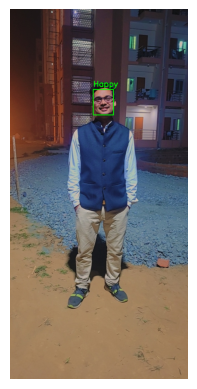

In [ ]:
face_detector = MTCNN()
def detect_emotion(image):

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Detect faces using MTCNN
    faces = face_detector.detect_faces(image)

    # Process each detected face
    for face in faces:
        x, y, width, height = face['box']
        x2, y2 = x + width, y + height

        # Extract the face region
        face_roi = gray[y:y2, x:x2]
        face_roi = cv2.resize(face_roi, (48, 48))

        # Normalize and reshape the face ROI
        face_roi = face_roi / 255.0
        face_roi = np.reshape(face_roi, (1, 48, 48, 1))

        # Perform emotion recognition
        emotion_predictions = model.predict(face_roi)
        emotion_label_argmax = np.argmax(emotion_predictions)
        emotion_label = emotion_labels[emotion_label_argmax]

        # Draw the predicted emotion label on the image
        cv2.putText(image, emotion_label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        cv2.rectangle(image, (x, y), (x2, y2), (0, 255, 0), 2)

    return image

# Load and process an image
image = cv2.imread('/content/Rachit2.jpeg')
output_image = detect_emotion(image)

# Display the result
plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()